In [1]:
import torch
from torch.utils.data import DataLoader, TensorDataset

from datasets import load_dataset
from transformers import AutoImageProcessor, AutoModel

import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score
from sklearn.decomposition import PCA

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/transformers/utils/hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


Device: cuda


### Load ViT and define encoder

In [2]:
vit_name = "google/vit-base-patch16-224-in21k"
vit_proc = AutoImageProcessor.from_pretrained(vit_name, use_fast=True)
vit_model = AutoModel.from_pretrained(vit_name).eval().to(device)

In [3]:
# Inspect embedding dimension D
dummy = torch.randn(1, 3, 224, 224).to(device)
with torch.no_grad():
    out_dummy = vit_model(pixel_values=dummy)
    # pooler_output is (1, D)
    D = out_dummy.pooler_output.shape[-1]
print("Embedding dim D:", D)


Embedding dim D: 768


#### Encode function

In [4]:
@torch.no_grad()
def encode_images_vit(pil_images):
    """
    pil_images: list of PIL.Image
    returns: torch.Tensor of shape (N, D)
    """
    inputs = vit_proc(images=pil_images, return_tensors="pt").to(device)
    out = vit_model(**inputs)
    emb = out.pooler_output  # (N, D)
    emb = torch.nn.functional.normalize(emb, p=2, dim=-1)
    return emb


### 1.2 – Build a small CIFAR subset

In [5]:
# Vision-only dataset
cifar = load_dataset("cifar10")
label_names = cifar["train"].features["label"].names
print("CIFAR-10 labels:", list(enumerate(label_names)))


CIFAR-10 labels: [(0, 'airplane'), (1, 'automobile'), (2, 'bird'), (3, 'cat'), (4, 'deer'), (5, 'dog'), (6, 'frog'), (7, 'horse'), (8, 'ship'), (9, 'truck')]


In [6]:
target_labels = [0, 3, 5]  # airplane, cat, dog
n_per_class = 200

images_small = []
labels_small = []

counts = {lbl: 0 for lbl in target_labels}

for ex in cifar["train"]:
    lbl = ex["label"]
    if lbl in target_labels and counts[lbl] < n_per_class:
        images_small.append(ex["img"])
        labels_small.append(lbl)
        counts[lbl] += 1
    if all(c >= n_per_class for c in counts.values()):
        break

print("Collected samples per class:", counts)
print("Total samples:", len(images_small))


Collected samples per class: {0: 200, 3: 200, 5: 200}
Total samples: 600


In [7]:
label_to_new = {old: i for i, old in enumerate(target_labels)}
labels_small = np.array([label_to_new[l] for l in labels_small])
num_classes = len(target_labels)
print("Num classes:", num_classes)


Num classes: 3


### 1.3 – Compute full embeddings once

In [ ]:
batch_size = 32
all_embs = []

for i in range(0, len(images_small), batch_size):
    batch_imgs = images_small[i : i + batch_size]
    emb = encode_images_vit(batch_imgs)  # (B, D)
    all_embs.append(emb.cpu())

full_embeddings = torch.cat(all_embs, dim=0)  # (N, D)
print("Full embeddings shape:", full_embeddings.shape)

Full embeddings shape: torch.Size([600, 768])


In [9]:
X = full_embeddings.numpy()  # (N, D)
y = labels_small             # (N,)
N, D = X.shape
print("N, D =", N, D)


N, D = 600 768


### Cosine similarity sanity check

In [10]:
from numpy.linalg import norm

def cosine_sim(u, v):
    return (u @ v) / (norm(u) * norm(v) + 1e-8)

print("Cosine sim of first sample with itself:", cosine_sim(X[0], X[0]))
print("Cosine sim first vs second sample:", cosine_sim(X[0], X[1]))


Cosine sim of first sample with itself: 1.0
Cosine sim first vs second sample: 0.41804653


### Truncation + k-means + plots

#### Helper functions for truncation and clustering

In [11]:
def l2_normalize_rows(arr, eps=1e-8):
    norms = np.linalg.norm(arr, axis=1, keepdims=True)
    norms = np.maximum(norms, eps)
    return arr / norms

def run_kmeans_and_nmi(X_d, y, k, random_state=42):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=random_state)
    cluster_ids = kmeans.fit_predict(X_d)
    nmi = normalized_mutual_info_score(y, cluster_ids)
    return nmi, cluster_ids


#### Main truncation experiment

In [12]:
dims = [max(8, D // 12), D // 6, D // 3, D // 2, D]
dims = sorted(set(dims))  # ensure unique and sorted

results = []

for d in dims:
    X_d = X[:, :d]              # truncate
    X_d = l2_normalize_rows(X_d)  # re-normalize
    
    nmi, clusters = run_kmeans_and_nmi(X_d, y, k=num_classes)
    results.append({"dim": d, "nmi": nmi, "clusters": clusters})
    print(f"Dim {d:4d}: NMI = {nmi:.4f}")


Dim   64: NMI = 0.7153
Dim  128: NMI = 0.7554
Dim  256: NMI = 0.7509
Dim  384: NMI = 0.7585
Dim  768: NMI = 0.7337


### Plot NMI vs dimension

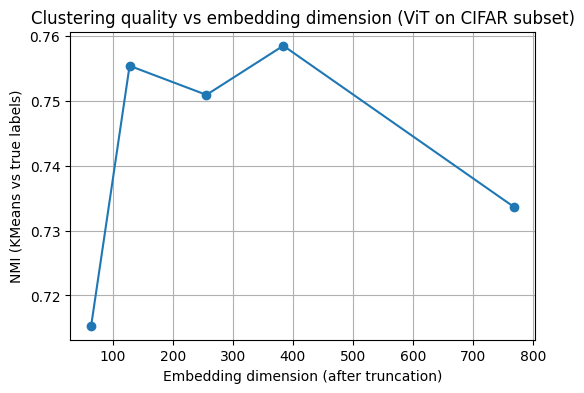

In [13]:
dims_list = [r["dim"] for r in results]
nmi_list = [r["nmi"] for r in results]

plt.figure(figsize=(6, 4))
plt.plot(dims_list, nmi_list, marker="o")
plt.xlabel("Embedding dimension (after truncation)")
plt.ylabel("NMI (KMeans vs true labels)")
plt.title("Clustering quality vs embedding dimension (ViT on CIFAR subset)")
plt.grid(True)
plt.show()


### PCA visualization of clusters

In [14]:
def pca_2d(X):
    pca = PCA(n_components=2, random_state=42)
    X_2d = pca.fit_transform(X)
    return X_2d


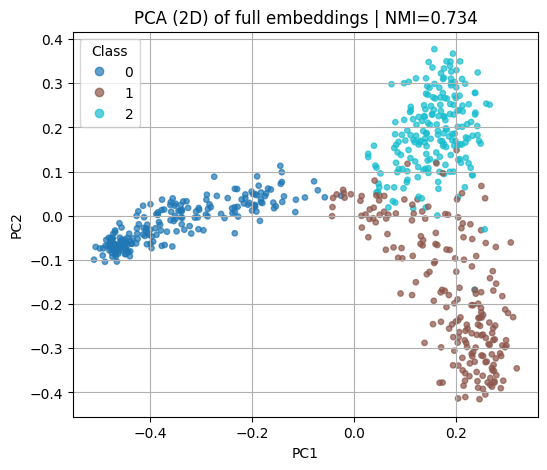

In [15]:
# Full dimension
X_full = l2_normalize_rows(X)
nmi_full, clusters_full = run_kmeans_and_nmi(X_full, y, k=num_classes)
X_full_2d = pca_2d(X_full)

plt.figure(figsize=(6, 5))
scatter = plt.scatter(X_full_2d[:, 0], X_full_2d[:, 1], c=y, s=15, alpha=0.7, cmap="tab10")
plt.legend(*scatter.legend_elements(), title="Class", loc="best")
plt.title(f"PCA (2D) of full embeddings | NMI={nmi_full:.3f}")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()


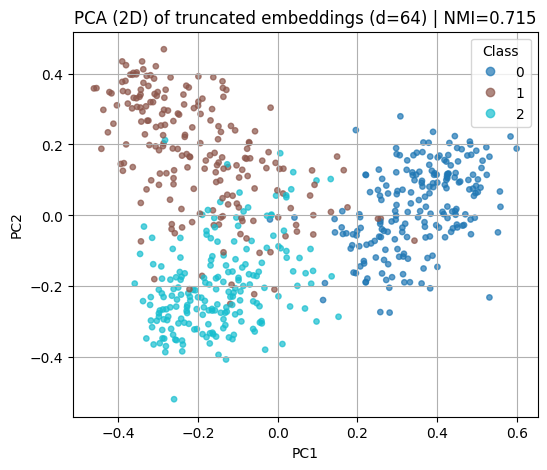

In [16]:
d_small = min(dims)  # smallest dimension we tried
X_small = l2_normalize_rows(X[:, :d_small])
nmi_small, clusters_small = run_kmeans_and_nmi(X_small, y, k=num_classes)
X_small_2d = pca_2d(X_small)

plt.figure(figsize=(6, 5))
scatter = plt.scatter(X_small_2d[:, 0], X_small_2d[:, 1], c=y, s=15, alpha=0.7, cmap="tab10")
plt.legend(*scatter.legend_elements(), title="Class", loc="best")
plt.title(f"PCA (2D) of truncated embeddings (d={d_small}) | NMI={nmi_small:.3f}")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()


## Experiment - 1.2

### Load CLIP model & processor

In [24]:
from PIL import Image
import requests
from io import BytesIO

In [17]:
from transformers import CLIPProcessor, CLIPModel
clip_name = "openai/clip-vit-base-patch32"
clip_proc = CLIPProcessor.from_pretrained(clip_name, use_fast=True)
clip_model = CLIPModel.from_pretrained(clip_name).eval().to(device)

In [18]:
# Inspect embedding dimension D
dummy_text = ["hello world"]
dummy_img = torch.randn(1, 3, 224, 224).to(device)

with torch.no_grad():
    # text
    text_inputs = clip_proc(text=dummy_text, return_tensors="pt", padding=True).to(device)
    text_feats = clip_model.get_text_features(**text_inputs)
    D_text = text_feats.shape[-1]

    # image
    img_inputs = {"pixel_values": dummy_img}
    img_feats = clip_model.get_image_features(**img_inputs)
    D_img = img_feats.shape[-1]



In [19]:
print("Text embedding dim:", D_text)
print("Image embedding dim:", D_img)
assert D_text == D_img
D = D_text

Text embedding dim: 512
Image embedding dim: 512


### Load a small dataset

In [ ]:
pixmo_cap = load_dataset("allenai/pixmo-cap", split="train[:100]")
print(pixmo_cap)
print(pixmo_cap[0])

Dataset({
    features: ['image_url', 'caption', 'transcripts'],
    num_rows: 100
})
{'image_url': 'https://pixmo.s3.us-west-2.amazonaws.com/birds/1491.png', 'caption': "This photograph depicts a striking black bird, possibly a grackle or similar species, perched on a white cement wall with red stains. The bird's sleek, elongated body is adorned with iridescent feathers that shimmer with shades of blue, purple, and green, most prominently on its wings and back. Its piercing yellow eye and long, sharp beak lend it a fierce, almost aerodynamic appearance. The bird's dark, slender legs and short talons grip the edge of the cement structure, which resembles a divider or barrier, possibly in an outdoor setting like a park or building patio. The background is a blur of green and white hues, hinting at lush tropical plants and tall trees, setting a serene, natural scene. The bird is poised, looking towards the upper right-hand corner of the frame, with its long tail feathers trailing elegant

In [ ]:
sample_count =10

In [ ]:
images = []
captions = []
for sample in range(0,sample_count):
   caption= pixmo_cap[sample]["caption"].strip()
   response = requests.get(pixmo_cap[sample]["image_url"])
   if response.status_code != 200:
       print(sample)
       continue
   else:
       try:
           image= Image.open(BytesIO(response.content))
           images.append(image)
           captions.append(caption)
       except Exception as e:
           print(f"Error loading image at index {sample}: {e}")

12
13
25
28
31
36
37
51
54
58
62
66
71
72
83
Error loading image at index 84: cannot identify image file <_io.BytesIO object at 0x7ffba02bdc10>
86
87


In [ ]:
N = len(images)
print("Num images:", N)
print("Example caption:", captions[0])

Num images: 82
Example caption: This photograph depicts a striking black bird, possibly a grackle or similar species, perched on a white cement wall with red stains. The bird's sleek, elongated body is adorned with iridescent feathers that shimmer with shades of blue, purple, and green, most prominently on its wings and back. Its piercing yellow eye and long, sharp beak lend it a fierce, almost aerodynamic appearance. The bird's dark, slender legs and short talons grip the edge of the cement structure, which resembles a divider or barrier, possibly in an outdoor setting like a park or building patio. The background is a blur of green and white hues, hinting at lush tropical plants and tall trees, setting a serene, natural scene. The bird is poised, looking towards the upper right-hand corner of the frame, with its long tail feathers trailing elegantly to the left.


### Encode images and texts with CLIP

In [ ]:
@torch.no_grad()
def encode_images_clip(pil_images, batch_size=8):
    all_feats = []
    for i in range(0, len(pil_images), batch_size):
        batch_imgs = pil_images[i : i + batch_size]
        inputs = clip_proc(images=batch_imgs, return_tensors="pt").to(device)
        feats = clip_model.get_image_features(**inputs)
        feats = torch.nn.functional.normalize(feats, dim=-1)
        all_feats.append(feats.cpu())
    return torch.cat(all_feats, dim=0)  # (N, D)

@torch.no_grad()
def encode_texts_clip(texts, batch_size=16):
    all_feats = []
    for i in range(0, len(texts), batch_size):
        batch_txt = texts[i : i + batch_size]
        inputs = clip_proc(text=batch_txt, return_tensors="pt", padding=True, truncation=True, max_length=77).to(device)
        feats = clip_model.get_text_features(**inputs)
        feats = torch.nn.functional.normalize(feats, dim=-1)
        all_feats.append(feats.cpu())
    return torch.cat(all_feats, dim=0)  # (M, D)


In [ ]:
img_emb_full = encode_images_clip(images)    # (N, D)
txt_emb_full = encode_texts_clip(captions)   # (N, D)

print("Image embeddings shape:", img_emb_full.shape)
print("Text embeddings shape:", txt_emb_full.shape)


Image embeddings shape: torch.Size([82, 512])
Text embeddings shape: torch.Size([82, 512])


### Retrieval metrics: Recall@K

In [ ]:
def compute_recall_at_k(sim_matrix, k=1):
    """
    sim_matrix: (N_images, M_captions)
    Assumes correct caption for image i is at index i.
    """
    N_images, M = sim_matrix.shape
    assert M >= N_images, "Here we assume at least one caption per image, aligned by index."

    # Larger similarity → better
    ranks = np.argsort(-sim_matrix, axis=1)  # sort descending

    hits = 0
    for i in range(N_images):
        top_k = ranks[i, :k]
        if i in top_k:
            hits += 1
    return hits / N_images


### Full-dimension baseline

In [ ]:
# Convert to numpy
E_img = img_emb_full.numpy()  # (N, D)
E_txt = txt_emb_full.numpy()  # (N, D)

# Similarity is just dot product since features are normalized
S_full = E_img @ E_txt.T  # (N, N)

r1_full = compute_recall_at_k(S_full, k=1)
r5_full = compute_recall_at_k(S_full, k=5)

print(f"Full dimension (D={D}) → Recall@1 = {r1_full:.3f}, Recall@5 = {r5_full:.3f}")


Full dimension (D=512) → Recall@1 = 0.976, Recall@5 = 1.000


### Truncation experiment

In [ ]:
def l2_normalize_rows(X, eps=1e-8):
    norms = np.linalg.norm(X, axis=1, keepdims=True)
    norms = np.maximum(norms, eps)
    return X / norms


In [ ]:
candidate_dims = [64, 128, 256, 512, D]
dims = sorted(set(d for d in candidate_dims if d <= D))

results = []

for d in dims:
    E_img_d = l2_normalize_rows(E_img[:, :d])
    E_txt_d = l2_normalize_rows(E_txt[:, :d])

    S_d = E_img_d @ E_txt_d.T

    r1 = compute_recall_at_k(S_d, k=1)
    r5 = compute_recall_at_k(S_d, k=5)

    results.append({"dim": d, "r1": r1, "r5": r5})
    print(f"d={d:4d}: Recall@1={r1:.3f}, Recall@5={r5:.3f}")


d=  64: Recall@1=0.549, Recall@5=0.878
d= 128: Recall@1=0.439, Recall@5=0.841
d= 256: Recall@1=0.963, Recall@5=0.988
d= 512: Recall@1=0.976, Recall@5=1.000


### Plots to visualize behavior

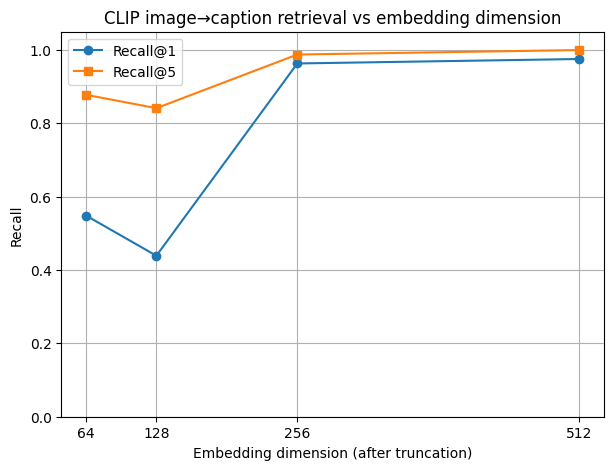

In [ ]:
dims_list = [r["dim"] for r in results]
r1_list   = [r["r1"]  for r in results]
r5_list   = [r["r5"]  for r in results]

plt.figure(figsize=(7, 5))
plt.plot(dims_list, r1_list, marker="o", label="Recall@1")
plt.plot(dims_list, r5_list, marker="s", label="Recall@5")
plt.xlabel("Embedding dimension (after truncation)")
plt.ylabel("Recall")
plt.title("CLIP image→caption retrieval vs embedding dimension")
plt.xticks(dims_list)
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend()
plt.show()


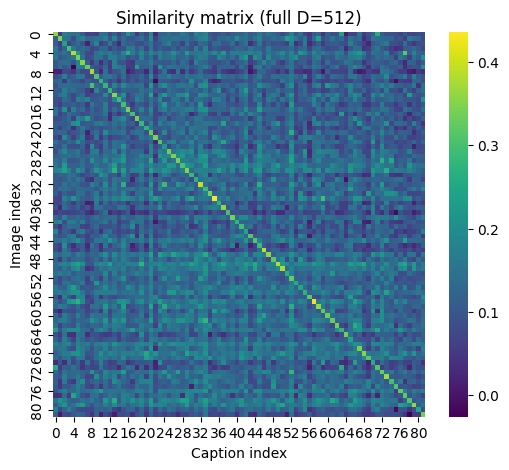

In [ ]:
import seaborn as sns  # if you don't have it: !pip install seaborn
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
sns.heatmap(S_full, cmap="viridis")
plt.title(f"Similarity matrix (full D={D})")
plt.xlabel("Caption index")
plt.ylabel("Image index")
plt.show()


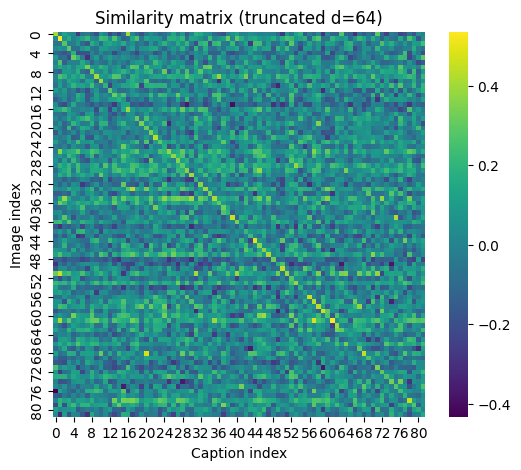

In [ ]:
d_small = min(dims)
E_img_small = l2_normalize_rows(E_img[:, :d_small])
E_txt_small = l2_normalize_rows(E_txt[:, :d_small])
S_small = E_img_small @ E_txt_small.T

plt.figure(figsize=(6, 5))
sns.heatmap(S_small, cmap="viridis")
plt.title(f"Similarity matrix (truncated d={d_small})")
plt.xlabel("Caption index")
plt.ylabel("Image index")
plt.show()
